Your Name and PRN:
- Name : Kunal Kurve and Manasi Malge 
- PRN  : 240340128012 and 240340128013

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

## Import Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2024-06-03 19:14:12.494224: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 19:14:12.542328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 19:14:12.542364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 19:14:12.543543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 19:14:12.550332: I tensorflow/core/platform/cpu_feature_guar

## Global Parameters

In [2]:
inpDir = r'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Assignments/inputs' # Location where input data is stored
outDir = r'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Assignments/outputs' # Location to store outsputs
modelDir = r'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Assignments/models' # Location of images
subDir = r'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Assignments/inputs/fashion_mnist'
logDir = r'/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Assignments/logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

EPOCHS = 50 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32
REG_LAMBDA = 0.05
TEST_SIZE = 0.2
# Early Stoping
PATIENCE = 20
LR_PATIENCE = 10
LR_Factor = 0.1 

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


## Helper functions

In [3]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------

def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
###---------------------------------------------------    
### Plot count of classes in training and testing sets
###---------------------------------------------------    
def fn_plot_labels(tr_ds, ts_ds, class_names = None):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    
    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1 
    
    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    ax.set_title('Training Set')
        
    # grids make it look good
    ax.grid()


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1 
    
    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)
    
    # add title
    ax.set_title('Test Set')
    

    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''
    
    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")

In [5]:
###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

## Basic Hygiene Check

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir)):
    os.makedirs(os.path.join(modelDir))
    print ('Created {} directory'.format(os.path.join(modelDir)))

if not os.path.exists(os.path.join(logDir)):
    os.makedirs(os.path.join(logDir))
    print ('Created {} directory'.format(os.path.join(logDir)))

## Load Fashion MNIST dataset

In [7]:
train_filename = os.path.join(inpDir, subDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, subDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [8]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',
               1:'Trouser',
               2:'Pullover',
               3:'Dress',
               4:'Coat',
               5:'Sandal', 
               6: 'Shirt',
               7: 'Sneaker', 
               8:'Bag', 
               9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [11]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [12]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [13]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [14]:
def split_feature_label(row):
    feature = tf.reshape(row[1:], [28,28,1])

    label = row[0]

    return feature, label

## Train DataSet

In [15]:
#Converting dataset into tesnorfolow
tmp_df_train = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_df_train.map(split_feature_label)
train_ds = train_ds.batch(BATCH_SIZE)

2024-06-03 19:14:20.247184: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


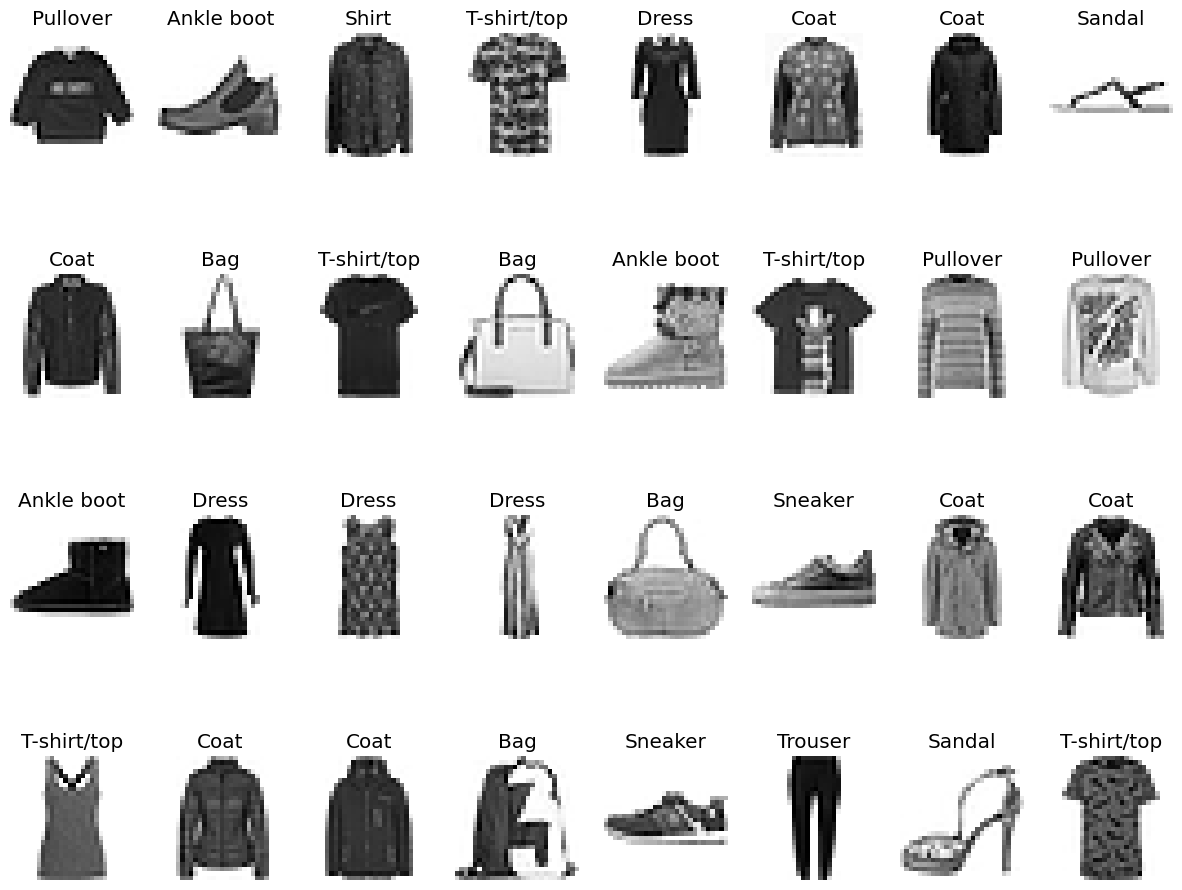

In [16]:

fig = plt.figure(figsize=(15, 12)) # figure size in inches

for images,labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'),
                    cmap = plt.cm.binary, 
                   interpolation='nearest') # sgow image on axis

        plt.title(class_names[labels[i].numpy()]) # Addd numbers (class) of images

        #plt.text(2,4, class_names[labels[i].numpy()], color ='b', fontsize = 12)

        plt.axis('off')

plt.show()

## For Test DataSet

In [17]:
# Coverting dataset into tenserflow
tmp_df_test = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_df_test.map(split_feature_label)
test_ds = test_ds.batch(BATCH_SIZE)

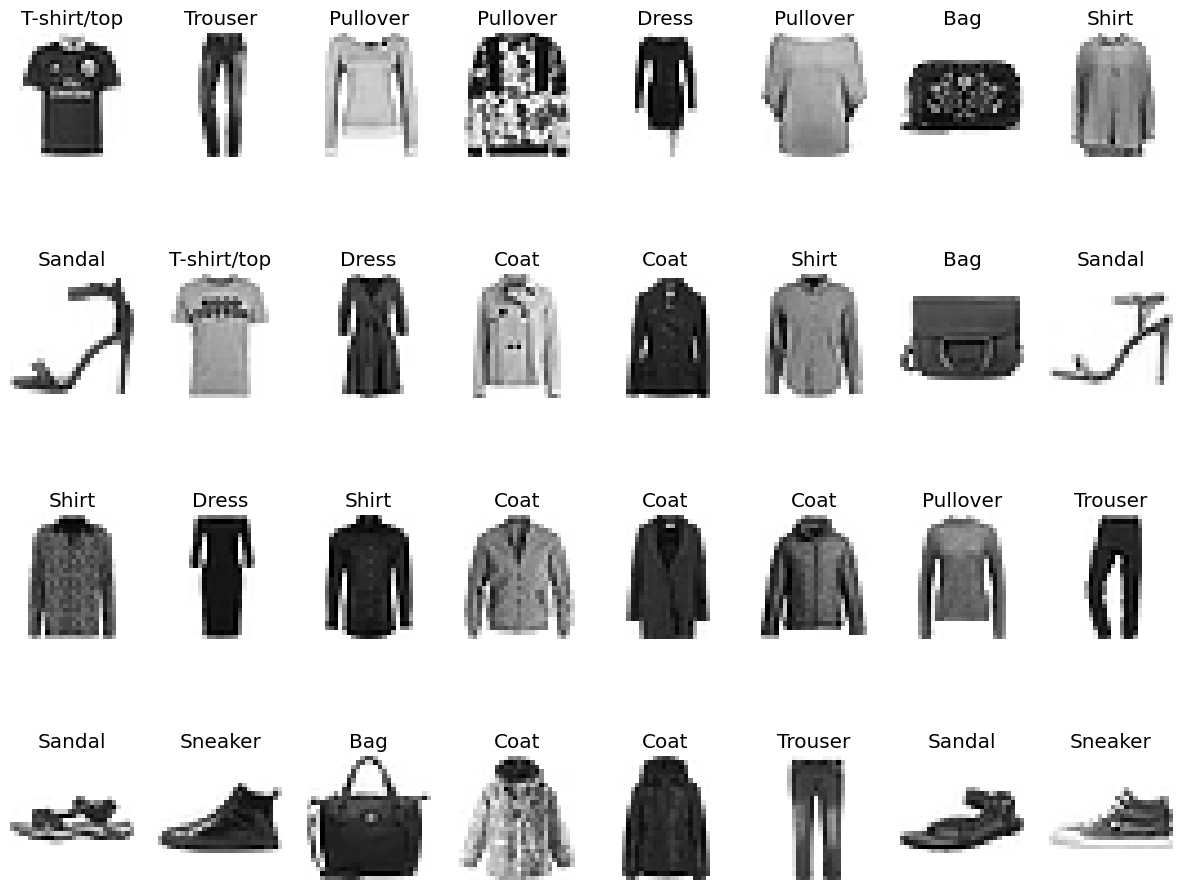

In [18]:

fig = plt.figure(figsize=(15, 12)) # figure size in inches

for images,labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'),
                    cmap = plt.cm.binary, 
                   interpolation='nearest') # sgow image on axis

        plt.title(class_names[labels[i].numpy()]) # Addd numbers (class) of images

        #plt.text(2,4, class_names[labels[i].numpy()], color ='b', fontsize = 12)

        plt.axis('off')

plt.show()

## Optimize for Performance

In [19]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Check shapes of train and test

In [20]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

for features1, labels1 in test_ds.take(1):
    print (features1.shape, labels1.shape)

(32, 28, 28, 1) (32,)
(32, 28, 28, 1) (32,)


2024-06-03 19:14:23.762344: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-03 19:14:23.788424: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
input_shape = [28,28,1]

## Define Model using L2 Regularization - RIDGE

In [22]:
k_reg = tf.keras.regularizers.L2(REG_LAMBDA)

model = tf.keras.Sequential()

# Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

##############################################################
# Convolutional Layers
##############################################################

############################## Set 1 ##############################
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape = input_shape)) 
# Expected output: 28x28x32
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Expected output; 14x14x32

############################## Set 2 ##############################
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu')) 
# Expected output: 12x12x64
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Expected output; 6x6x64

############################## Set 3 ##############################
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu')) 
# Expected output: 4x4x128

## Head

In [23]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = k_reg))
model.add(tf.keras.layers.Dense(10))

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
history = model.fit( train_ds,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = test_ds)

Epoch 1/50
1875/1875 [==============================] - 29s 15ms/step - loss: 0.7169 - accuracy: 0.8072 - val_loss: 0.4670 - val_accuracy: 0.8731
Epoch 2/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4589 - accuracy: 0.8671 - val_loss: 0.4137 - val_accuracy: 0.8797
Epoch 3/50
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4085 - accuracy: 0.8817 - val_loss: 0.3864 - val_accuracy: 0.8851
Epoch 4/50
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3767 - accuracy: 0.8905 - val_loss: 0.3784 - val_accuracy: 0.8879
Epoch 5/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3518 - accuracy: 0.8984 - val_loss: 0.3680 - val_accuracy: 0.8906
Epoch 6/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3322 - accuracy: 0.9043 - val_loss: 0.3690 - val_accuracy: 0.8876
Epoch 7/50
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3162 - accuracy: 0.9095 - val_loss: 0.3692 -

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         7

In [27]:
checkpoint_path = os.path.join(modelDir, subDir, 'MNIST_DATASET') # save the model
log_dir = os.path.join(logDir,'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

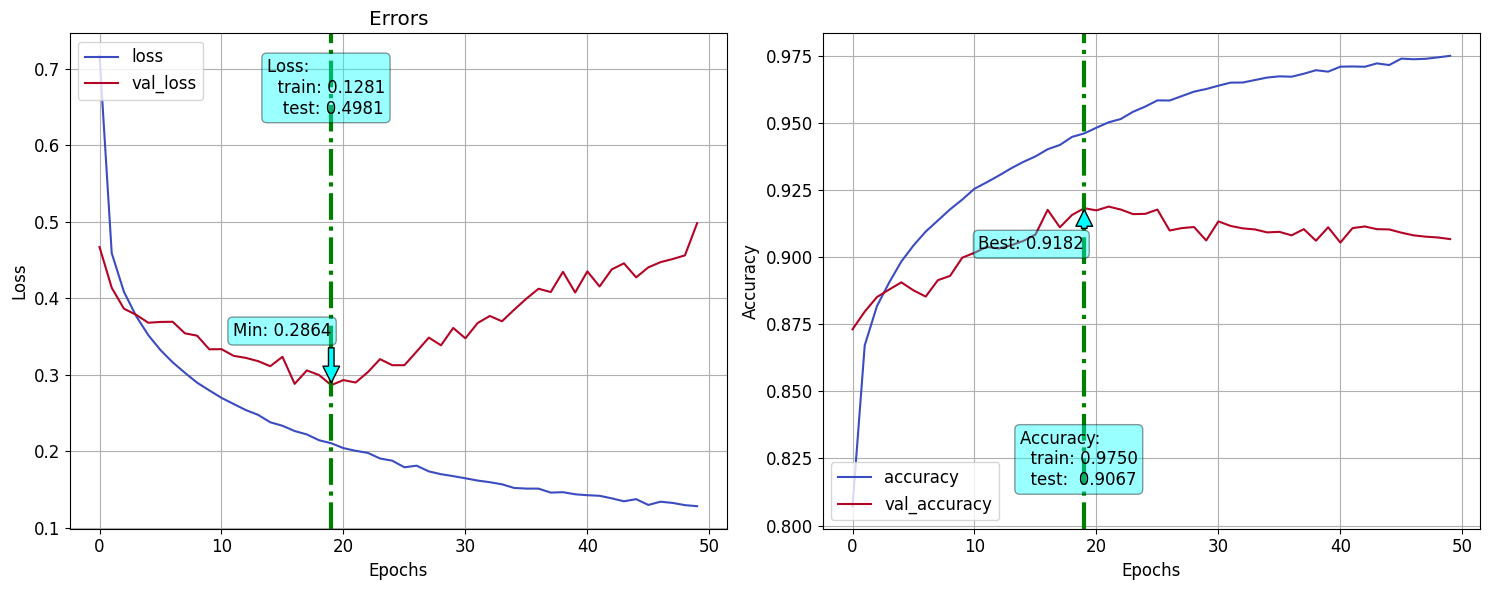

In [28]:
fn_plot_tf_hist(pd.DataFrame(history.history))

##### With L2 Regularization, Accuracy is 0.9041 and min loss is 0.4576

## Model with  drop out and L2 regularization

In [29]:
k_reg = tf.keras.regularizers.L2(REG_LAMBDA)
dor1 = 0.10
dor2 = 0.15
dor3 = 0.20
dor4 = 0.25

model = tf.keras.Sequential()

# Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

##############################################################
# Convolutional Layers
##############################################################

############################## Set 1 ##############################
model.add(tf.keras.layers.Conv2D(32, 3, padding='same',kernel_regularizer = k_reg, activation='relu', input_shape = [28, 28, 1])) 
# Expected output: 28x28x32
model.add(tf.keras.layers.Dropout(dor1))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
# Expected output; 14x14x32

############################## Set 2 ##############################
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu')) 
# Expected output: 12x12x64
model.add(tf.keras.layers.Dropout(dor2))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Expected output; 6x6x64

############################## Set 3 ##############################
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu')) 
# Expected output: 4x4x128
model.add(tf.keras.layers.Dropout(dor3))

## Head

In [30]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = k_reg))
model.add(tf.keras.layers.Dropout(dor4))
model.add(tf.keras.layers.Dense(10))

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
checkpoint_path = os.path.join(modelDir, subDir, 'MNIST_DATASET') # save the model
log_dir = os.path.join(logDir,'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
history1 = model.fit( train_ds,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = test_ds)

Epoch 1/50
1875/1875 [==============================] - 38s 20ms/step - loss: 0.8918 - accuracy: 0.7733 - val_loss: 0.6625 - val_accuracy: 0.8341
Epoch 2/50
1875/1875 [==============================] - 37s 20ms/step - loss: 0.6395 - accuracy: 0.8338 - val_loss: 0.5958 - val_accuracy: 0.8563
Epoch 3/50
1875/1875 [==============================] - 37s 19ms/step - loss: 0.5854 - accuracy: 0.8496 - val_loss: 0.5587 - val_accuracy: 0.8707
Epoch 4/50
1875/1875 [==============================] - 37s 20ms/step - loss: 0.5558 - accuracy: 0.8591 - val_loss: 0.5195 - val_accuracy: 0.8755
Epoch 5/50
1875/1875 [==============================] - 36s 19ms/step - loss: 0.5328 - accuracy: 0.8645 - val_loss: 0.5137 - val_accuracy: 0.8746
Epoch 6/50
1875/1875 [==============================] - 37s 20ms/step - loss: 0.5193 - accuracy: 0.8686 - val_loss: 0.4997 - val_accuracy: 0.8757
Epoch 7/50
1875/1875 [==============================] - 37s 20ms/step - loss: 0.5035 - accuracy: 0.8749 - val_loss: 0.4959 -

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                      

In [ ]:
fn_plot_tf_hist(pd.DataFrame(history1.history))

#### With L2 regularition and drop out Accuracy is 0.8121 and min loss is 0.6322

## Model with L2 reuglarization, early stopping and batch normalization

In [ ]:
# Model creating

k_init = tf.keras.initializers.GlorotUniform(seed =  RANDOM_STATE)
k_reg = tf.keras.regularizers.L2(l2 =  REG_LAMBDA)

dor1 = 0.4
dor = 0.3
dor3 = 0.2
dor4 = 0.12

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28],name="inputLayer"),

    # Set Layer1
    tf.keras.layers.Dense(300,
                           kernel_initializer =  k_init,
                           kernel_regularizer = k_reg,
                           name="hiddenLayer1"),

     # BN1
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),

    # Set Layer2
    tf.keras.layers.Dense(100, 
                          kernel_initializer =  k_init,
                          kernel_regularizer = k_reg,
                          name="hiddenLayer2"),
    # BN2
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.ReLU(),


    # Output Layer
    tf.keras.layers.Dense(10, activation="softmax", name="outputLayer")
])

In [ ]:
checkpoint_path = os.path.join(modelDir, subDir, 'MNIST_DATASET') # save the model

early_stoping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE, # it will contiue for given patience value after that stop
    verbose=2,
    mode='auto',
    restore_best_weights=True, # It restore the best weight before 20 epochs
)

log_dir = os.path.join(logDir,'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
loss_fn =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

optimizer =  tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(optimizer =  optimizer,loss  =  loss_fn,metrics=['accuracy'])

In [ ]:
history =  model.fit(train_ds,
                     validation_data=test_ds,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS,
                     callbacks = [early_stoping_callback],
                     verbose=2)

In [ ]:
h3 = pd.DataFrame(history.history)
fn_plot_tf_hist(h3)

#### With L2 regularition,batch normalization and early stopping out Accuracy is 0.8476 and min loss is 0.4709

### we save model with reularization L2 which gives best accuracy

In [ ]:
#Saving the model
model.save("model.h1")